# Calculating sulfur and trace element evaluation during mantle melting with changing SCSS and K$_D$s
- This notebook shows how to use the mantle melting model of Lee et al. (2012) adapted by Wieser et al. (2020) to model how S, Cu and other chalcophile or lithophile elements evolve during mantle melting
- For more information on how the math works, we direct you towards the supporting information of Wieser et al (2020) - https://doi.org/10.1016/j.gca.2020.05.018 - Where the equations are typed out in detail
- Here, we do the more complex example where

## Loading libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PySulfSat as ss

## Example 1 - Non fixed S content
- The examples in the other workbook assume that S is fixed throughout the melting interval
- However, we know the concentration of mantle melts changes with increasing F, so ideally, we'd calculate how much S those melts can hold
- We can do this using an output from a melting model (here, Thermocalc). 

In [2]:
# Load a generic dataframe
Thermocalc_df=pd.read_excel('Thermocalc_Melting_Path.xlsx')

In [3]:
# Load a dataframe for calculating SCSS for these melt comps
Thermo_df_ss=ss.import_data('Thermocalc_Melting_Path.xlsx', 
                    suffix='_Liq')

We have replaced all missing liquid oxides and strings with zeros. 


### Extract the modes from Thermocalc

In [4]:
Modes3=pd.DataFrame(data={'ol': Thermocalc_df['ol'],
                        'cpx': Thermocalc_df['cpx'],
                        'opx': Thermocalc_df['opx'],
                        'sp': Thermocalc_df['sp'],
                        'gt': Thermocalc_df['g']*0})

### Lets calculate the SCSS using ONeill (2021)
- Wieser et al. (2020) show that the calculated sulfide composition isn't very reliable at mantle PT, so we use a fixed mantle S composition of Fe/(Fe+Ni+Cu)=0.634

In [5]:
SCSS_fixedSulf=ss.calculate_O2021_SCSS(df=Thermo_df_ss,
T_K=Thermocalc_df['T']+273.15, P_kbar=Thermocalc_df['P'],
Fe_FeNiCu_Sulf=0.634)
SCSS_fixedSulf.head()

Using inputted Fe_FeNiCu_Sulf ratio for calculations.


,SCSS2_ppm,LnS,Ln_a_FeO,Ln_a_FeS,DeltaG,LnCS2_calc,SiO2_Liq,TiO2_Liq,Al2O3_Liq,FeOt_Liq,...,Cu Aggregated (200 ppm S),S aggregated (200 ppm S),Cu instantaneous (150 ppm S),Cu Aggregated (150 ppm S),S aggregated (150 ppm S),Cu instantaneous (100 ppm S),Cu Aggregated (100 ppm S),S aggregated (100 ppm S),S Instant (SCSS),Fe_FeNiCu_Sulf_calc
0,1015.610668,6.923245,-2.229336,-0.529123,6.105676,-0.882644,48.30,0.0,15.09,9.40,...,0.000000,1094.512966,0.000000,0.000000,1094.512966,0.000000,0.000000,1094.512966,1094.512966,0.634
1,1026.745602,6.934149,-2.231155,-0.529223,6.098787,-0.866569,48.20,0.0,15.07,9.41,...,69.809653,1094.512966,81.443325,81.443325,1094.512966,97.729855,97.729855,1094.512966,1094.512966,0.634
2,1037.848819,6.944905,-2.233686,-0.529344,6.091909,-0.851345,48.11,0.0,15.04,9.42,...,70.208767,1165.713498,82.517835,81.980580,1165.713498,99.263590,98.496722,1165.713498,1236.914031,0.634
3,1049.219776,6.955802,-2.235786,-0.529426,6.085093,-0.835650,48.02,0.0,15.02,9.43,...,70.634378,1196.253703,83.710621,82.557260,1196.253703,100.988882,99.327442,1196.253703,1257.334112,0.634
4,1060.441357,6.966440,-2.237817,-0.529535,6.078288,-0.820130,47.93,0.0,14.99,9.44,...,71.082028,1213.727431,84.999914,83.167924,1213.727431,102.880676,100.215751,1213.727431,1266.148614,0.634


### Now we are ready to model S-Cu
- instead of inputting a single value for S_melt_SCSS_2, we input the pandas dataframe. 

In [14]:
KDs_Cu=pd.DataFrame(data={'element': 'Cu',
        'ol': 0.048, 'opx': 0.034, 
        'cpx': 0.043, 'sp': 0.223, 
        'gt': 0, 'sulf': 800}, index=[0])

Modes=pd.DataFrame(data={'ol': 0.6, 'opx': 0.2, 
       'cpx': 0.18, 'sp': 0.02, 'gt': 0}, index=[0])

# Lets run the simple model for comparison
S_Sulf = 38*(10**4)
df_Cu_200S=ss.Lee_Wieser_sulfide_melting(N=len(Modes3), Modes=Modes,
                        M_Max=0.2,
                        KDs=KDs_Cu,
                        S_Sulf=S_Sulf, elem_Per=30,
                        S_Mantle=[200],
                        S_Melt_SCSS_2=1000,
                         Prop_S6=0)
# Now lets change S

df_Cu_200S_Thermocalc=ss.Lee_Wieser_sulfide_melting(N=len(Modes3), 
                        Modes=Modes3,
                        M_Max=0.01,
                        KDs=KDs_Cu,
                        S_Sulf=S_Sulf, elem_Per=30,
                        S_Mantle=[200],
                        S_Melt_SCSS_2=SCSS_fixedSulf['SCSS2_ppm'],
                         Prop_S6=0)

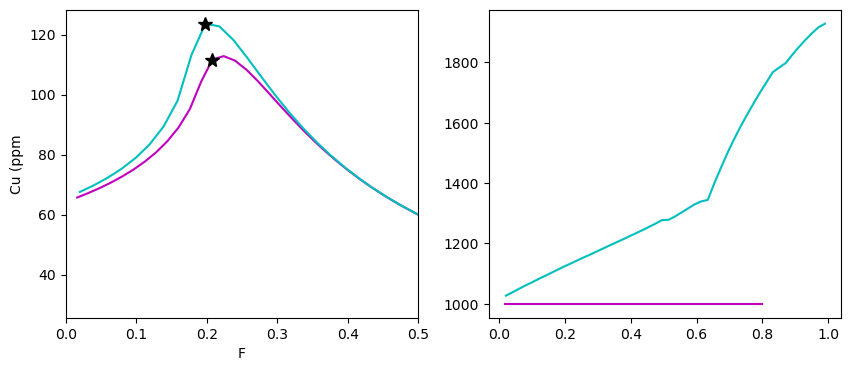

In [22]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10,4))
# 100 ppm
ax1.plot(df_Cu_200S['F'].iloc[1:], 
         df_Cu_200S['Cu_Melt_Agg'].iloc[1:],
        '-',color='m', ms=10, label='Cu, S=200, fixed SCSS')
# Lets add a cross to show the point at which sulfide is exhausted
sulf_out_200=np.take(np.where(df_Cu_200S['S_Residue']==0), 0)
ax1.plot(df_Cu_200S['F'].loc[sulf_out_200], 
         df_Cu_200S['Cu_Melt_Agg'].loc[sulf_out_200],
        '*k', ms=10, label='Sulf out')


ax1.plot(df_Cu_200S_Thermocalc['F'].iloc[1:], 
         df_Cu_200S_Thermocalc['Cu_Melt_Agg'].iloc[1:],
        '-',color='c', ms=10, label='Cu, S=200, fixed SCSS')
# Lets add a cross to show the point at which sulfide is exhausted
sulf_out_200=np.take(np.where(df_Cu_200S_Thermocalc['S_Residue']==0), 0)
ax1.plot(df_Cu_200S_Thermocalc['F'].loc[sulf_out_200], 
         df_Cu_200S_Thermocalc['Cu_Melt_Agg'].loc[sulf_out_200],
        '*k', ms=10, label='Sulf out')
ax1.set_xlim([0, 0.5])
ax1.set_xlabel('F')
ax1.set_ylabel('Cu (ppm')

# Plot S in source
ax2.plot(df_Cu_200S['F'].iloc[1:], 
         df_Cu_200S['S_Melt'].iloc[1:],
        '-',color='m', ms=10, label='Cu, S=200, fixed SCSS')

ax2.plot(df_Cu_200S_Thermocalc['F'].iloc[1:], 
         df_Cu_200S_Thermocalc['S_Melt'].iloc[1:],
        '-',color='c', ms=10, label='Cu, S=200, fixed SCSS')

## Example 4 - Variable KD
- We can be even 'cleverer' than this. So far, we have assumed the KDs stay constant, but that isn't the case. We know from Kiseeva et al. (2015) that the KD of Cu in the sulfide depends on the FeOt content of the melt, the sulfide composition and the temperature. 
- So what we do first, is we create 

In [ ]:
df_Ba_200S_changeSi=ss.Lee_Wieser_sulfide_melting(N=3000, 
                        Modes=Modes2,
                        M_Max=0.01,
                        KDs=KDs_Ba,
                        S_Sulf=363636, elem_Per=30,
                        S_Mantle=[200],
                        S_Melt_SCSS_2=980.7872088,
                         Prop_S6=0)
df_Ba_200S_changeSi.head()


g:\my drive\berkeley_new\pysulfsat\pysulfsat_structure\src\PySulfSat\mantle_melting.py:42: UserWarning: You have inputted a dataframe of silicate modes that doesnt match the number of steps you asked for. We are changing the number of steps to match the length of your dataframe
  w.warn('You have inputted a dataframe of silicate modes that doesnt match the number of steps you asked for. We are changing the number of steps to match the length of your dataframe')


,F,M,Ba_KD,Ba_Melt_Agg,Ba_Melt_Inst,Ba_residue,S_residue,S_Melt,XSulf
0,0.000000,1.000000,0.004534,0.000000,0.000000,30.000000,200.000000,980.787209,0.000550
1,0.000764,0.999236,0.004534,5666.018119,5666.018119,25.688087,199.402648,980.787209,0.000548
2,0.001529,0.998471,0.004533,5258.648753,4851.279386,21.993376,198.804381,980.787209,0.000547
3,0.002293,0.997707,0.004533,4890.170026,4153.212573,18.827887,198.205198,980.787209,0.000545
4,0.003058,0.996942,0.004533,4556.422344,3555.179297,16.116129,197.605096,980.787209,0.000543


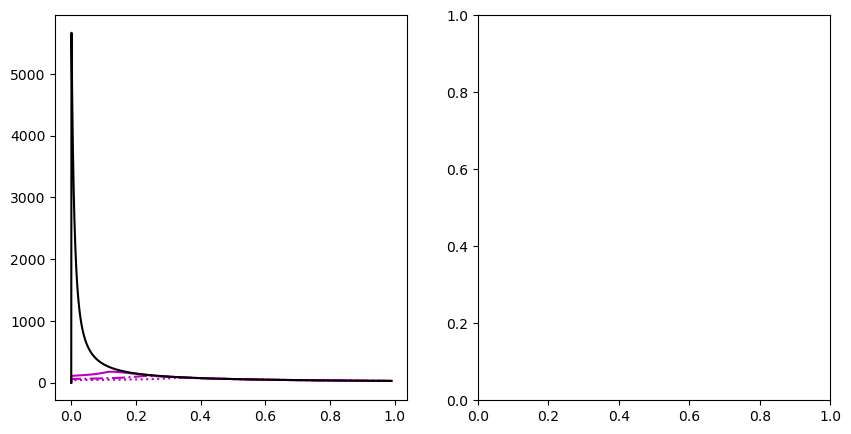

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(df_Cu_200S_changeSi['F'],
         df_Cu_200S_changeSi['Cu_Melt_Agg'],
         '-.', color='m')
ax1.plot(df_Cu_300S_changeSi['F'],
         df_Cu_300S_changeSi['Cu_Melt_Agg'],
         ':', color='m')
ax1.plot(df_Cu_100S_changeSi['F'],
         df_Cu_100S_changeSi['Cu_Melt_Agg'],
         '-', color='m')
ax1.plot(df_Ba_200S_changeSi['F'],
         df_Ba_200S_changeSi['Ba_Melt_Agg'],
         '-', color='k')
         

In [ ]:
elx='Cu'
ely='100'
M=np.linspace(0, 1, 100)
Kd_Cu=M*0.1
df_out_S0=pd.DataFrame(data={'F': 1-M,
                        'M': M,                     
                    '{}_KD_{}'.format(elx, ely): Kd_Cu})
df_out_S0 

,F,M,Cu_KD_100
0,1.000000,0.000000,0.00000
1,0.989899,0.010101,0.00101
2,0.979798,0.020202,0.00202
3,0.969697,0.030303,0.00303
4,0.959596,0.040404,0.00404
...,...,...,...
95,0.040404,0.959596,0.09596
96,0.030303,0.969697,0.09697
97,0.020202,0.979798,0.09798
98,0.010101,0.989899,0.09899


In [ ]:
plt.plot(df_Ba_200S_changeSi['F'],
